In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_gray(img):  
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    
img = cv2.imread('archive/lena.jpg')

In [3]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 1000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (21, 21),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [209]:
# Take first frame and find corners in it
old_frame = cv2.imread('archive/IMG_0101.JPG')

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

In [210]:
def dist(x1,y1,x2,y2):
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2,2))

def check_alarm(global_shape, p1, st, p0):
    s1, s2, _ = global_shape
    global_dist = dist(s1, 0, s2, 0)
    
    number_of_points_with_long_dist = 0
    good_new = p1[st==1]
    good_old = p0[st==1]
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        if(dist(a,b, c,d) / global_dist > 0.1):
            number_of_points_with_long_dist += 1
            
    print('number_of_points_with_long_dist:', number_of_points_with_long_dist)  
    print('number_of_all_points:', len(p0))
    
    if ((float)(number_of_points_with_long_dist) / len(p0) > 0.1):
        print("SOS")
    else:
        print("OK")

('number_of_points_with_long_dist:', 0)
('number_of_all_points:', 60)
OK


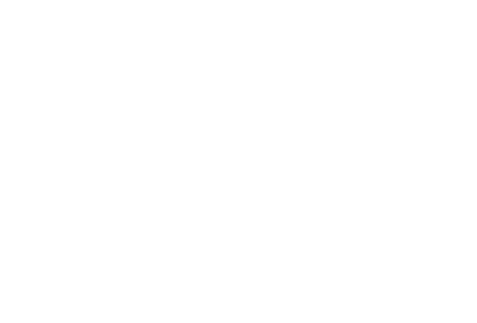

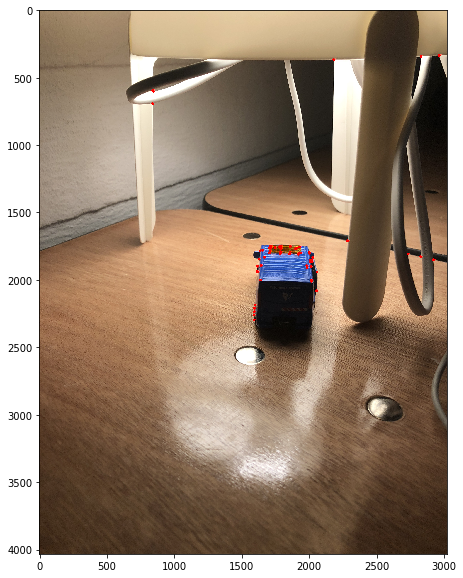

In [211]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame = cv2.imread('archive/IMG_0102.JPG')
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

check_alarm(frame.shape, p1, st, p0)

# Select good points
good_new = p1[st==1]
good_old = p0[st==1]
# draw the tracks
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 10)
    frame = cv2.circle(frame,(a,b), 5, (0,0,255), 10)
    
img = cv2.add(frame, mask)
show(img)

In [256]:
vidcap = cv2.VideoCapture('archive/IMG_0110.MOV')

In [408]:
def turn(image):
    rows,cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    
    return dst

vidcap = cv2.VideoCapture('archive/IMG_0110.MOV')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    if (not success):
        break  
        
    image = turn(image)
    cv2.imwrite('frames/' + str(count) + '_frame.png', image)
    
    count += 1

In [342]:
import json
json_list = json.loads('[{"top": 190, "left": 1035, "bottom": 423, "right": 1459}, {"top": 11, "left": 401, "bottom": 121, "right": 502}]')

In [378]:
img = cv2.imread('first_frame.png')
for json in json_list:
    top = json['top']
    bottom = json['bottom']
    left = json['left']
    right = json['right']
    print(top, left, bottom, right)
    cv2.rectangle(img, (left,top),(right,bottom),(0,255,0),5)

(190, 1035, 423, 1459)
(11, 401, 121, 502)


### Production

In [9]:
def dist(x1,y1,x2,y2):
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2,2))

def check_alarm(global_shape, p1, st, p0):
    s1, s2, _ = global_shape
    global_dist = dist(s1, 0, s2, 0)
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    number_of_points_with_long_dist = 0
    for i, (new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        print(dist(a,b,c,d))
        
        if (dist(a,b,c,d) / global_dist > 0.1):
            number_of_points_with_long_dist += 1
               
    return ((float)(number_of_points_with_long_dist) / len(p0[st==1]) > 0.3)

In [10]:
def cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, img):
    s1, s2, _ = img.shape
    cuted_img = img[rect_top:rect_bottom, rect_left:rect_right, :]
    
    return cuted_img

def check_for_stealing(rect_left, rect_top, rect_right, rect_bottom, first_img_path, second_img_path):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 1000, 
                           qualityLevel = 0.3, 
                           minDistance = 3, 
                           blockSize = 3)

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (21, 21), 
                     maxLevel = 10, 
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Take first frame and find corners in it
    first_img = cv2.imread(first_img_path)
    
    old_frame = cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, first_img)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    
    second_img = cv2.imread(second_img_path)
    frame = cut_rectangle(rect_left, rect_top, rect_right, rect_bottom, second_img)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), (0,0,255), 2)
        frame = cv2.circle(frame,(a,b), 5, (0,0,255), 2)
    
    img = cv2.add(frame, mask)
    show(img)
    
    check_alarm(frame.shape, p1, st, p0)
    
    return old_frame, frame

In [15]:
#Stepan/bigbro/archive/3_44.jpeg&path2=/Users/Stepan/bigbro/archive/3_45.jpeg&top=600&left=566&bottom=850&right=980

import json
json_coordinates = json.loads('{"top": 600, "left": 566, "bottom": 850, "right": 980}')

top = json_coordinates['top']
bottom = json_coordinates['bottom']
left = json_coordinates['left']
right = json_coordinates['right']
print(top, left, bottom, right)

(600, 566, 850, 980)


90.8438598252
47.658600624
90.0313195562
49.3803209465
117.903619939
10.2954801905
206.209619347
1.87759491079
70.5929100982
60.9701351
228.084307068
47.6082355597
29.1343483693
109.683482961
1.9168351966
1.88534789063
80.2569712856
58.9641614717
77.9411421495
64.6090235568
203.728041047
68.5771721985
13.7312308447
25.6352752106
90.5081286838
1.89826032779
100.500029032
20.8207567641
305.253329561
96.4805487413


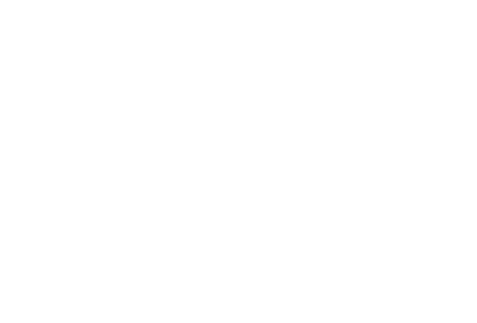

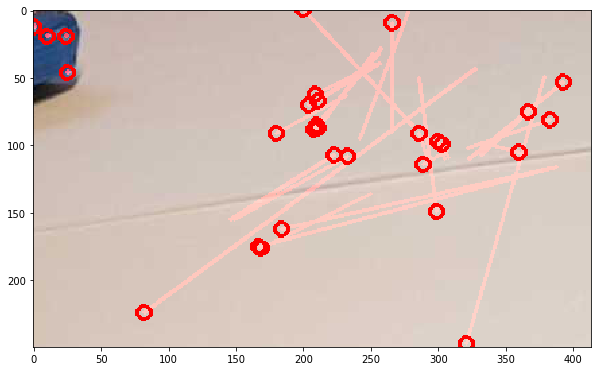

In [16]:
old_frame, frame = check_for_stealing(left, top, right, bottom, 'archive/3_44.jpeg', 'archive/3_45.jpeg')

In [84]:
img1 = cv2.imread('archive/3_44.jpeg')
img2 = cv2.imread('archive/3_45.jpeg')

In [85]:
# load the two input images
imageA = cut_rectangle(left, top, right, bottom, img1)
imageB = cut_rectangle(left, top, right, bottom, img2)
 
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

In [86]:
frame_diff = cv2.absdiff(grayA,grayB)

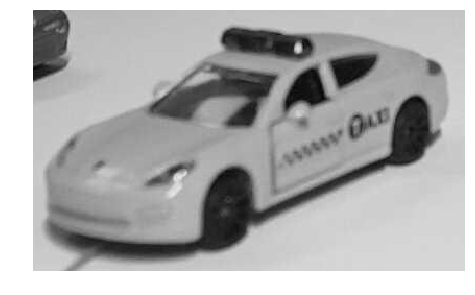

In [87]:
show_gray(grayA)

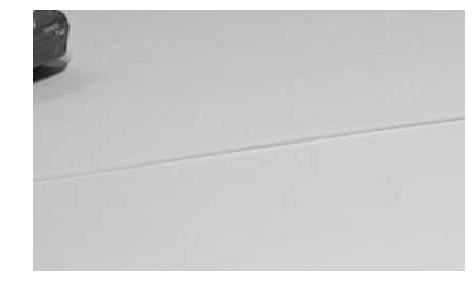

In [88]:
show_gray(grayB)

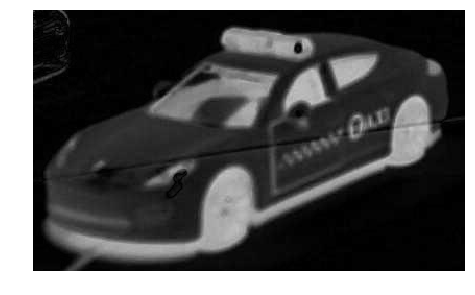

In [89]:
show_gray(frame_diff)

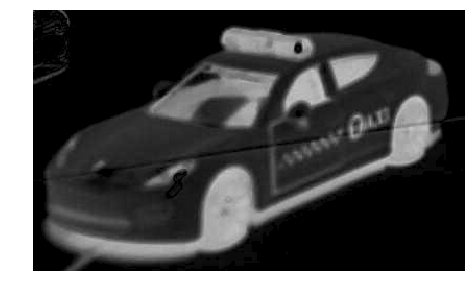

In [90]:
frame_diff[frame_diff < 10] = 0
show_gray(frame_diff)

In [67]:
s1, s2 = frame_diff.shape

In [68]:
s = np.sum(frame_diff != 0)

In [70]:
(float)(s) / (s1 * s2) 

0.26964251207729467